# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
from cv2 import imread
from skimage.transform import resize as imresize
import datetime
import os
import warnings
import abc
from sys import getsizeof
import cv2
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

import random as rn
from keras import backend as K
import tensorflow as tf

We set the random seed so that the results don't vary drastically.

In [ ]:
warnings.filterwarnings("ignore")
%matplotlib inline
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [ ]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive

drive.mount('/content/gdrive')
root_folder = 'gdrive/My Drive/GestureRecognition/Project_data'

Mounted at /content/gdrive


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,root_folder):
        self.document_train = np.random.permutation(open(root_folder + '/' + 'train.csv').readlines())
        self.document_validation = np.random.permutation(open(root_folder + '/' + 'val.csv').readlines())
        self.path_train = root_folder + '/' + 'train'
        self.path_validation =  root_folder + '/' + 'val'
        self.num_seq_train = len(self.document_train)
        self.num_seq_validation = len(self.document_validation)
        
    def initialize_prop_images(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,sample_frames=30,batch_size=20,num_epochs=20):
        self.sample_frames=sample_frames
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.sample_frames)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.path_train, self.document_train,augment=augment_data)
        val_generator = self.generator(self.path_validation, self.document_validation)

        model_name = 'gdrive/My Drive/GestureRecognition/'+'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_seq_train%self.batch_size) == 0:
            steps_per_epoch = int(self.num_seq_train/self.batch_size)
        else:
            steps_per_epoch = (self.num_seq_train//self.batch_size) + 1

        if (self.num_seq_validation%self.batch_size) == 0:
            validation_steps = int(self.num_seq_validation/self.batch_size)
        else:
            validation_steps = (self.num_seq_validation//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# Initial Model

In [ ]:
class ModelConv3DSample(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.sample_frames,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [ ]:
conv_3d1 = ModelConv3DSample()
conv_3d1.initialize_path(root_folder)
conv_3d1.initialize_prop_images(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(sample_frames=30,batch_size=40,num_epochs=1)
conv_3d1_model = conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 32)    1

## Experimenting with Image resolution and batch_size: Please refer to write-up for the experimentation results

### We had issues with hitting memory limit on resources with image resolution of 160x160 with 30 frames and batch_size of 40, getting the below error:
ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

##### We may want to tweak the resolution and the batch size to optimize the model

# Model with reduced number of parameters (*Model 4 from the writeup*)

In [ ]:
class ModelConv3DReducedParams(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.sample_frames,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d_reduced_params = ModelConv3DReducedParams()
conv_3d_reduced_params.initialize_path(root_folder)
conv_3d_reduced_params.initialize_prop_images(image_height=120,image_width=120)
conv_3d_reduced_params.initialize_hyperparams(sample_frames=16,batch_size=20,num_epochs=30)
conv_3d_reduced_params_model = conv_3d_reduced_params.define_model(dense_neurons=64,dropout=0.25)
conv_3d_reduced_params_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_4 (Activation)    (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_5 (Activation)    (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 60, 60, 16)    

In [ ]:
print("Prameter Count:", conv_3d_reduced_params_model.count_params())
history_model_reduced_params = conv_3d_reduced_params.train_model(conv_3d_reduced_params_model, augment_data=True)

Prameter Count: 230949
Epoch 1/30
34/34 [==============================] - 3531s 106s/step - loss: 2.0534 - categorical_accuracy: 0.2871 - val_loss: 1.7053 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to gdrive/My Drive/GestureRecognition/model_init_2021-05-0211_14_22.433357/model-00001-1.88932-0.32127-1.70535-0.22000.h5
Epoch 2/30
34/34 [==============================] - 221s 7s/step - loss: 1.4819 - categorical_accuracy: 0.4416 - val_loss: 2.2313 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to gdrive/My Drive/GestureRecognition/model_init_2021-05-0211_14_22.433357/model-00002-1.42520-0.46456-2.23133-0.21000.h5
Epoch 3/30
34/34 [==============================] - 219s 7s/step - loss: 1.1777 - categorical_accuracy: 0.5665 - val_loss: 2.6002 - val_categorical_accuracy: 0.2200

Epoch 00003: saving model to gdrive/My Drive/GestureRecognition/model_init_2021-05-0211_14_22.433357/model-00003-1.20318-0.55732-2.60023-0.22000.h5
Epoch 4/30
34/34 [==============

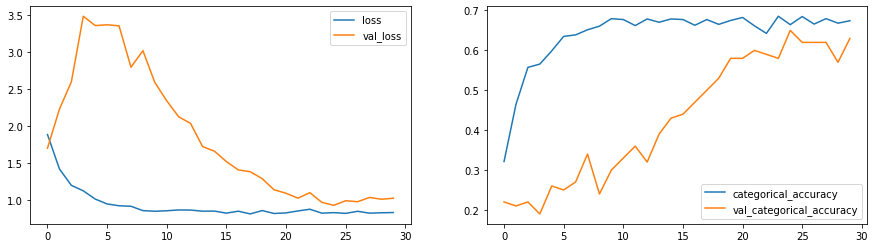

In [ ]:
plot(history_model_reduced_params)

In [ ]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,root_folder):
        self.document_train = np.random.permutation(open(root_folder + '/' + 'train.csv').readlines())
        self.document_validation = np.random.permutation(open(root_folder + '/' + 'val.csv').readlines())
        self.path_train = root_folder + '/' + 'train'
        self.path_validation =  root_folder + '/' + 'val'
        self.num_seq_train = len(self.document_train)
        self.num_seq_validation = len(self.document_validation)
        
    def initialize_prop_images(self,image_height=100, image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,sample_frames=30, batch_size=20, num_epochs=20):
        self.sample_frames=sample_frames
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0, self.total_frames-1, self.sample_frames)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq = len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment):
            batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized = imresize(image, (self.image_height, self.image_width, 3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]) / 255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]) / 255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) / 255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        return(batch_data,batch_labels)
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.path_train, self.document_train,augment=augment_data)
        val_generator = self.generator(self.path_validation, self.document_validation)

        model_name = 'gdrive/My Drive/GestureRecognition/'+'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_seq_train%self.batch_size) == 0:
            steps_per_epoch = int(self.num_seq_train/self.batch_size)
        else:
            steps_per_epoch = (self.num_seq_train//self.batch_size) + 1

        if (self.num_seq_validation%self.batch_size) == 0:
            validation_steps = int(self.num_seq_validation/self.batch_size)
        else:
            validation_steps = (self.num_seq_validation//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history
        
    @abc.abstractmethod
    def define_model(self):
        pass

# (3,3,3) kernel & 160x160 res with augmetation (*Model 5 as in write-up*)

In [ ]:
class ModelConv3DReducedResolution(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.sample_frames,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d_reduced_resolution = ModelConv3DReducedResolution()
conv_3d_reduced_resolution.initialize_path(root_folder)
conv_3d_reduced_resolution.initialize_prop_images(image_height=160, image_width=160)
conv_3d_reduced_resolution.initialize_hyperparams(sample_frames=20, batch_size=20, num_epochs=30)
conv_3d_reduced_resolution_model=conv_3d_reduced_resolution.define_model(dense_neurons=256, dropout=0.5)
conv_3d_reduced_resolution_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_9 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 10, 80, 80, 32)   

In [ ]:
print("Prameter Count:", conv_3d_reduced_resolution_model.count_params())
history_model_reduced_resolution=conv_3d_reduced_resolution.train_model(conv_3d_reduced_resolution_model,augment_data=True)

Prameter Count: 3638981
Epoch 1/30
34/34 [==============================] - 1986s 60s/step - loss: 2.1726 - categorical_accuracy: 0.3228 - val_loss: 2.4517 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to gdrive/My Drive/GestureRecognition/model_init_2021-05-0214_01_04.473521/model-00001-1.92150-0.38084-2.45170-0.16000.h5
Epoch 2/30
34/34 [==============================] - 320s 10s/step - loss: 1.3644 - categorical_accuracy: 0.5169 - val_loss: 3.8960 - val_categorical_accuracy: 0.1700

Epoch 00002: saving model to gdrive/My Drive/GestureRecognition/model_init_2021-05-0214_01_04.473521/model-00002-1.41042-0.52640-3.89596-0.17000.h5
Epoch 3/30
34/34 [==============================] - 320s 10s/step - loss: 1.2979 - categorical_accuracy: 0.5651 - val_loss: 5.2795 - val_categorical_accuracy: 0.1900

Epoch 00003: saving model to gdrive/My Drive/GestureRecognition/model_init_2021-05-0214_01_04.473521/model-00003-1.33176-0.54902-5.27951-0.19000.h5
Epoch 4/30
34/34 [============

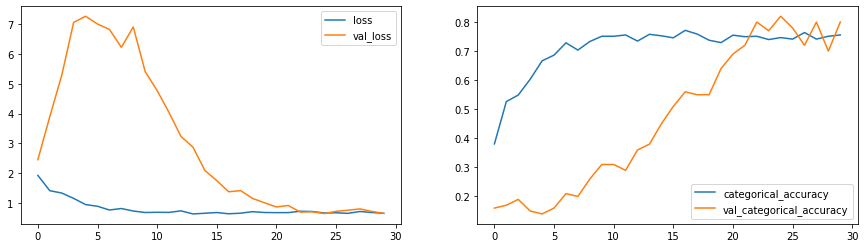

In [ ]:
plot(history_model_reduced_resolution)

# Transfer Learning on RNN-CNN model with GRU -  Final model (Best performance) - (*Model 7 as in write-up*)

In [ ]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.sample_frames,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
rnn_cnn_tl = RNNCNN_TL()
rnn_cnn_tl.initialize_path(root_folder)
rnn_cnn_tl.initialize_prop_images(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(sample_frames=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 128)               443136    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

In [ ]:
print("Paremeter Count:", rnn_cnn_tl_model.count_params())
history_model_rnn_cnn_tl=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Paremeter Count: 3693253
Epoch 1/20
133/133 [==============================] - 242s 2s/step - loss: 1.3669 - categorical_accuracy: 0.4414 - val_loss: 0.9016 - val_categorical_accuracy: 0.6900

Epoch 00001: saving model to gdrive/My Drive/GestureRecognition/model_init_2021-05-0217_09_56.323457/model-00001-1.09820-0.54902-0.90158-0.69000.h5
Epoch 2/20
133/133 [==============================] - 234s 2s/step - loss: 0.7697 - categorical_accuracy: 0.7162 - val_loss: 0.4207 - val_categorical_accuracy: 0.8500

Epoch 00002: saving model to gdrive/My Drive/GestureRecognition/model_init_2021-05-0217_09_56.323457/model-00002-0.75094-0.72247-0.42068-0.85000.h5
Epoch 3/20
133/133 [==============================] - 235s 2s/step - loss: 0.4915 - categorical_accuracy: 0.8108 - val_loss: 0.4291 - val_categorical_accuracy: 0.8600

Epoch 00003: saving model to gdrive/My Drive/GestureRecognition/model_init_2021-05-0217_09_56.323457/model-00003-0.52109-0.82127-0.42911-0.86000.h5
Epoch 4/20
133/133 [=======

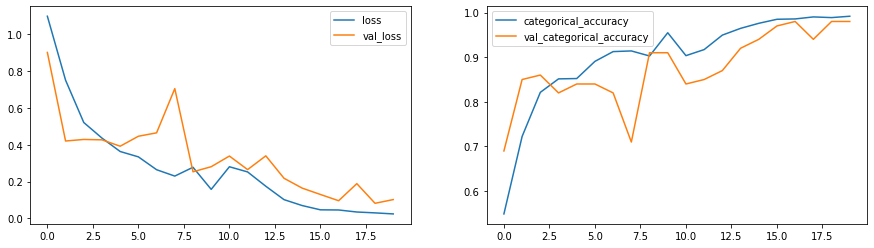

In [ ]:
plot(history_model_rnn_cnn_tl)

# Loading Model and testing

In [ ]:
import time
from keras.models import load_model
model = load_model('gdrive/My Drive/GestureRecognition/model_init_2021-05-0217_09_56.323457/model-00018-0.03509-0.99020-0.18905-0.94000.h5')

In [ ]:
test_generator=RNNCNN_TL()
test_generator.initialize_path(root_folder)
test_generator.initialize_prop_images(image_height=120,image_width=120)
test_generator.initialize_hyperparams(sample_frames=16,batch_size=5,num_epochs=20)

g=test_generator.generator(test_generator.path_validation,test_generator.document_validation,augment=False)
batch_data, batch_labels=next(g)

In [ ]:
batch_labels

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[2 0 4 4 0]


##**The best model obtained was with Transfer learning on RNN-CNN model with GRU. The training accuracy obtained was of 99.23% and the validation accuracy was 98%. From the above snippet to test our model, we see that for the first batch of 5 image-sequences, 4 were correctly classified. This also verifies that we are successfully able to load the model from the disk for further reusability.** 